In [86]:
import re
import joblib
import stanza
import warnings
import numpy as np
import pandas as pd
import altair as alt
from tqdm import tqdm
import seaborn as sns
import xgboost as  xgb
from sklearn.svm import SVC
from turkishnlp import detector
from sklearn.metrics import accuracy_score
from scipy.sparse import vstack, csr_matrix
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv("trendyol_reviews.csv")

In [61]:
df

,rating,review_text
0,1,Ozmak kozmetik satıcısından aldım urun sahte c...
1,1,Çok kötü. yağlı bir cildim olmasına rağmen Cil...
2,1,yagli ve çok hassas bir cildim var. asssiri ku...
3,1,Değişen bişey Yok
4,1,Ürün orijinal değildi iade ettim başka bir sat...
...,...,...
9995,0,"Bittikçe alıyorum, çok güzel kesinlikle alın"
9996,0,Kızıma aldım çok sevdi
9997,0,güzel kardeşime aldım
9998,0,Gerçekten rahatlıkla alabileceğiniz bir ürün t...


In [62]:
df.isna().value_counts()

rating  review_text
False   False          10000
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

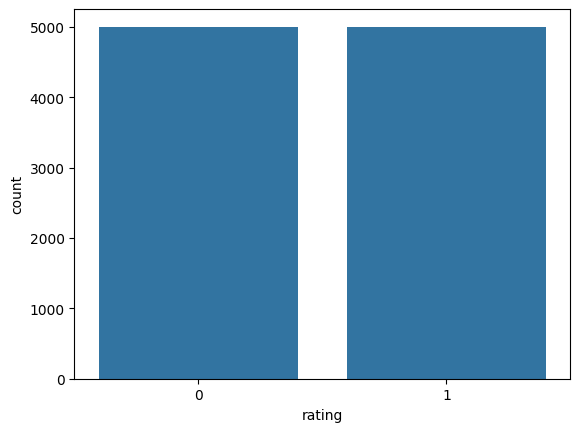

In [63]:
sns.countplot(data=df, x='rating')

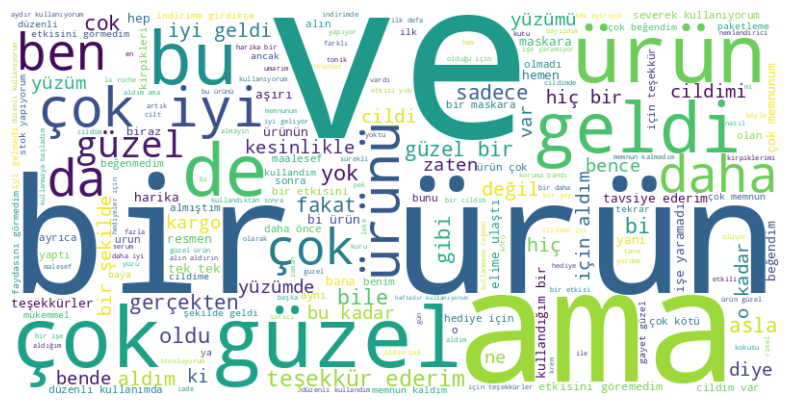

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text = ' '.join(df['review_text'])

wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [65]:
# Stopword listesi
turkce_stopwords = [
    "ben", "sen", "o", "biz", "siz", "onlar", "bana", "bende", "beni", "seni", "sana", "ona", "onu", "bizim", "sizden", "onlardan",
    "ile", "ve", "veya", "ya", "de", "da", "ki", "mi", "mı", "mu", "mü", "ise", "ama", "fakat", "lakin", "ancak", "çünkü", "yani","ne", 
    "kim", "hangi", "neden", "nasıl", "kaç", "nerede", "nereden", "nereye", "niçin","şimdi", "daha", "önce", "sonra", "az", "çok", "hep", 
    "hiç", "henüz", "hala", "artık", "bile", "zaten", "bir", "birkaç", "birçok", "her", "herkes", "herhangi", "bazı", "biri", "şey", "şöyle", 
    "böyle", "gibi", "tüm", "defa", "kere", "olmak", "etmek", "yapmak", "bulmak", "vermek", "almak", "gelmek", "gitmek", "demek", "bilmek", 
    "istemek", "görmek", "durmak", "kalmak", "dı", "di", "du", "dü", "tı", "ti", "tu", "tü", "miş", "mış", "muş", "müş", "ken", "meden", 
    "ince", "erek", "arak", "ecek", "acak", "malı", "meli", "vs", "vs.", "vb", "vb.", "şuan", "şimdi", "ayrıca", "bence", "sanırım", 
    "galiba", "oluyor", "oldu", "olacak", "olsun", "etmiş", "etmişti", "ediyor", "edilecek", "edildi", "etti", "her zaman", "genelde", 
    "çoğu zaman", "bugün", "yarın", "dün", "şu an", "hala", "burada", "orada", "şurda", "burası", "orası", "haha", "lol", "omg", "aynen", 
    "yaaa", "yaa", "hıı", "hmm", "hadi", "evet", "hayır", "teşekkürler", "sağol", "selam", "merhaba", "hoş", "sevgiler", "kendim", 
    "kendine", "kendini", "kendimiz", "kendi", "senin", "sizin", "bizim", "onun", "bunun", "şunun", "kimse", "herkes", "birisi"
]

def temizle_stopwords(metin, stopword_list):
    kelimeler = metin.split()
    temizlenmis = [kelime for kelime in kelimeler if kelime not in stopword_list]
    return " ".join(temizlenmis)

In [66]:
def remove_emojis(metin):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # yüz ifadeleri
        "\U0001F300-\U0001F5FF"  # sembol & ikonlar
        "\U0001F680-\U0001F6FF"  # ulaşım & harita
        "\U0001F1E0-\U0001F1FF"  # bayraklar
        "\U00002700-\U000027BF"  # çeşitli semboller
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', metin)

In [67]:
def temizle(metin):
    metin = metin.lower()
    metin = re.sub(r'\d+', '', metin)
    metin = re.sub(r'http[s]?://\S+', '', metin)
    metin = re.sub(r'([!?.])\1+', r'\1', metin)
    return metin

In [68]:
# Pipeline fonksiyonu
def full_pipeline(metin):
    metin = temizle(metin)
    metin = remove_emojis(metin)
    metin = temizle_stopwords(metin, turkce_stopwords)
    return metin

In [ ]:
df = pd.read_csv("trendyol_reviews.csv")  
df["cleaned_review"] = df["review_text"].apply(full_pipeline)
df_cleaned = df[["rating", "cleaned_review"]]
df_cleaned.to_csv("dataset.csv", index=False)

In [70]:
df = pd.read_csv("dataset.csv")

In [71]:
df = df.dropna()
df

,rating,cleaned_review
0,1,ozmak kozmetik satıcısından aldım urun sahte c...
1,1,kötü. yağlı cildim olmasına rağmen cildimi aşı...
2,1,yagli hassas cildim var. asssiri kuruttu
3,1,değişen bişey yok
4,1,ürün orijinal değildi iade ettim başka satıcıd...
...,...,...
9995,0,"bittikçe alıyorum, güzel kesinlikle alın"
9996,0,kızıma aldım sevdi
9997,0,güzel kardeşime aldım
9998,0,gerçekten rahatlıkla alabileceğiniz ürün tek k...


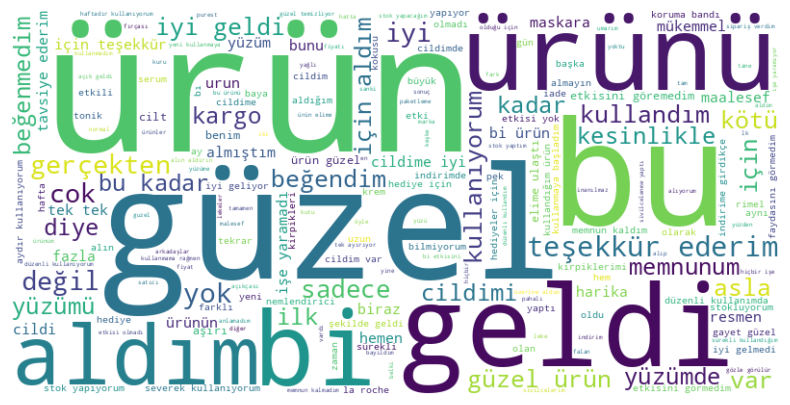

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text = ' '.join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
y = df['rating'] 
metin = df['cleaned_review'].to_list()

In [74]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(metin)

CountVectorizer(binary=True)

In [ ]:
transformed_text=vectorizer.transform(metin)
transformed_text=pd.DataFrame.sparse.from_spmatrix(transformed_text)
transformed_text
mapped_text=transformed_text.rename(columns={v: k for k, v in vectorizer.vocabulary_.items()})
mapped_text

,aa,aaaa,aayy,abartanlar,abarti,abartilacak,abartilan,abartildi,abartildigi,abartili,...,şüphesi,şüphesiz,şık,şımdılık,şşe,şşş,əla,əlada,əladı,əlimə
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(metin)

TfidfVectorizer()

In [ ]:
transformed_text=vectorizer.transform(metin) 
transformed_text=pd.DataFrame.sparse.from_spmatrix(transformed_text)
transformed_text
mapped_text=transformed_text.rename(columns={v: k for k, v in vectorizer.vocabulary_.items()})
mapped_text

,aa,aaaa,aayy,abartanlar,abarti,abartilacak,abartilan,abartildi,abartildigi,abartili,...,şüphesi,şüphesiz,şık,şımdılık,şşe,şşş,əla,əlada,əladı,əlimə
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vectorizer_svm = TfidfVectorizer()
X_svm = vectorizer_svm.fit_transform(metin)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, test_size=0.2, random_state=42)

# SVM Modeli
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_svm, y_train_svm)
y_pred_svm = model_svm.predict(X_test_svm)
print("SVM Accuracy:", accuracy_score(y_test_svm, y_pred_svm, normalize=True))
print(classification_report(y_test_svm, y_pred_svm))
print("test cross val skor:" , cross_val_score(model_svm, X_test_svm, y_test_svm, cv=10).mean())

SVM Accuracy: 0.9259629814907454
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       993
           1       0.94      0.92      0.93      1006

    accuracy                           0.93      1999
   macro avg       0.93      0.93      0.93      1999
weighted avg       0.93      0.93      0.93      1999

test cross val skor: 0.9024547738693467


In [ ]:
vectorizer_rf = CountVectorizer(binary=True)
X_rf = vectorizer_rf.fit_transform(metin)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Random Forest Modeli
model_rf = RandomForestClassifier()
model_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = model_rf.predict(X_test_rf)
print("Random Forest Accuracy:", accuracy_score(y_test_rf, y_pred_rf, normalize=True))
print(classification_report(y_test_rf, y_pred_rf))
print("test cross val skor:" , cross_val_score(model_rf, X_test_rf, y_test_rf, cv=10).mean())

Random Forest Accuracy: 0.8954477238619309
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       993
           1       0.90      0.89      0.90      1006

    accuracy                           0.90      1999
   macro avg       0.90      0.90      0.90      1999
weighted avg       0.90      0.90      0.90      1999

test cross val skor: 0.8679246231155779


In [ ]:
vectorizer_log = TfidfVectorizer()
X_log = vectorizer_log.fit_transform(metin)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, test_size=0.2, random_state=42)

# Logistic Regression Modeli
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train_log, y_train_log)
y_pred_log = model_log.predict(X_test_log)
print("Logistic Regression Accuracy:", accuracy_score(y_test_log, y_pred_log, normalize=True))
print(classification_report(y_test_log, y_pred_log))
print("test cross val skor:" , cross_val_score(model_log, X_test_log, y_test_log, cv=10).mean())

Logistic Regression Accuracy: 0.9214607303651826
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       993
           1       0.91      0.93      0.92      1006

    accuracy                           0.92      1999
   macro avg       0.92      0.92      0.92      1999
weighted avg       0.92      0.92      0.92      1999

test cross val skor: 0.8954497487437185


In [ ]:
vectorizer_nb = CountVectorizer(binary=True)
X_nb = vectorizer_nb.fit_transform(metin)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y, test_size=0.2, random_state=42)

# Multinomial Naive Bayes Modeli
nb_model = MultinomialNB()
nb_model.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_model.predict(X_test_nb)
print("Multinomial Accuracy:", accuracy_score(y_test_nb, y_pred_nb))
print(classification_report(y_test_nb, y_pred_nb))
print("Cross-validation Score:", cross_val_score(nb_model, X_test_nb, y_test_nb, cv=10).mean())
joblib.dump(nb_model, "naive_bayes_model.pkl")
joblib.dump(vectorizer_nb, "naive_bayes_vectorizer.pkl")

Multinomial Accuracy: 0.9254627313656828
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       993
           1       0.96      0.89      0.92      1006

    accuracy                           0.93      1999
   macro avg       0.93      0.93      0.93      1999
weighted avg       0.93      0.93      0.93      1999

Cross-validation Score: 0.8994396984924624


['naive_bayes_vectorizer.pkl']

In [83]:
vectorizer_xgb = CountVectorizer(binary=True)
X_xgb = vectorizer_xgb.fit_transform(metin)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y, test_size=0.2, random_state=42)

# XGBoost Modeli
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)
print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print(classification_report(y_test_xgb, y_pred_xgb))
print("Cross-val score:", cross_val_score(model_xgb, X_test_xgb, y_test_xgb, cv=10).mean())

XGBoost Accuracy: 0.8914457228614308
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       993
           1       0.88      0.90      0.89      1006

    accuracy                           0.89      1999
   macro avg       0.89      0.89      0.89      1999
weighted avg       0.89      0.89      0.89      1999

Cross-val score: 0.8709296482412061


In [ ]:
yeni_metin = "Beğendim, günlük kullanıma gayet uygun bir ürün.Paketleme çok iyi- sağlam. Teşekkür ederim."
yeni_metin = yeni_metin.lower()
yeni_metin = yeni_metin.replace('[^\w\s]', '')
yeni_metin_vektoru = vectorizer.transform([yeni_metin])
tahmin = nb_model.predict(yeni_metin_vektoru)
print("Tahmin edilen duygu: ", tahmin)

Tahmin edilen duygu:  [0]
